<a href="https://colab.research.google.com/github/FCUAIC/Basic-ML/blob/main/mnist_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Demo

作者: 梁定殷

版權歸FCUAI所有

Input shape: (1, 28, 28)

## 超參數(Hyperparameters)

In [ ]:
# 學習率(Learning Rate), LR越大模型越有自信, LR越小模型越沒自信
LR = 0.001
# 每次學習要看過多少的Batch後才更新模型
BATCH_SIZE = 256
# 學習次數
EPOCHS = 10

用離線的MNIST = True # Pytorch的MNIST暫時不能用

## 載入需要用的Package

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adadelta
from torch.nn import CrossEntropyLoss
from torchsummary import summary

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

if 用離線的MNIST:
    from keras.datasets import mnist
else:
    from torchvision.datasets import MNIST


from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

## 模型

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.cnn = nn.Sequential(
            # in: 1x28x28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            # in: 32x26x26
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.Dropout(),
            nn.ReLU(),
            # in: 64x24x24
            nn.Flatten(),
            # out: 36864
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=36864, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=10),
        )
    
    def forward(self, x):
        x = self.cnn(x)
        return self.fc(x)

model = MNISTModel().cuda()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
           Dropout-4           [-1, 64, 24, 24]               0
              ReLU-5           [-1, 64, 24, 24]               0
           Flatten-6                [-1, 36864]               0
            Linear-7                 [-1, 1024]      37,749,760
              ReLU-8                 [-1, 1024]               0
            Linear-9                   [-1, 10]          10,250
Total params: 37,778,826
Trainable params: 37,778,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.47
Params size (MB): 144.11
Estimated Total Size (MB): 145.59
---------------------------------

## 資料集(Dataset)

In [ ]:
class MNISTDataset(Dataset):
    """
        這是我們定義的Dataset
    """
    def __init__(self, train=False, transformer=None):
        # 從Keras載入MNIST
        (train_feature, train_label), (test_feature, test_label) = mnist.load_data()
        if train:
            # 我們只要訓練的
            self.data = np.array([list(d) for d in zip(train_feature, train_label)], dtype=object)
            self.length = len(train_feature)
        else:
            # 我們只要測試的
            self.data = np.array([list(d) for d in zip(test_feature, test_label)], dtype=object)
            self.length = len(test_feature)
        
        self.transformer = transformer

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 對data做轉換
        if self.transformer:
            img, label = self.data[idx]
            return self.transformer(img), torch.tensor(label, dtype=torch.long)
        return self.data[idx]

## 載入資料集(Dataset)

In [ ]:
preprocessor = transforms.Compose([
    transforms.ToTensor() #轉成Tensor的時候會做歸一化(Normalize)
    ])


if 用離線的MNIST:
    print('使用離線的Dataset.')
    mnist_train = MNISTDataset(train=True, transformer=preprocessor)
    mnist_test = MNISTDataset(train=False, transformer=preprocessor)
else:
    print('使用Pytorch的Dataset.')
    mnist_train = MNIST(root='mnist', download=True, transform=preprocessor, train=True)
    mnist_test = MNIST(root='mnist', transform=preprocessor, train=False)

print(f'訓練資料一共有{len(mnist_train)}筆資料\n測試資料一共有{len(mnist_test)}筆資料')


mnist_train = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True) # 我們想要打散訓練資料的順序
mnist_test = DataLoader(mnist_test, batch_size=1)

使用離線的Dataset.
訓練資料一共有60000筆資料
測試資料一共有10000筆資料


## 來看一下我們的資料

In [ ]:
if 用離線的MNIST:
    preview_train = MNISTDataset(train=True)
else:
    preview_train = MNIST(root='mnist', download=True, transform=None, train=True)

# 找出第一個0-9在dataset裡的位置
indexs = [-1]*10
for i, batch in enumerate(preview_train):
    # 如果已經抓好的話,提早結束
    if indexs.count(-1) == 0:
        break
    # 把一個batch拆開, img是圖片, label是圖片的數字
    img, label = batch
    # 只有還沒有抓到位置的數字才會做indexs[label] = i
    if indexs[label] < 0: 
        indexs[label] = i
# 輸出結果
for num, idx in enumerate(indexs):
    print(f'第一張數字 {num}的圖片出現在dataset的第 {idx}個位置')
print(indexs)

第一張數字 0的圖片出現在dataset的第 1個位置
第一張數字 1的圖片出現在dataset的第 3個位置
第一張數字 2的圖片出現在dataset的第 5個位置
第一張數字 3的圖片出現在dataset的第 7個位置
第一張數字 4的圖片出現在dataset的第 2個位置
第一張數字 5的圖片出現在dataset的第 0個位置
第一張數字 6的圖片出現在dataset的第 13個位置
第一張數字 7的圖片出現在dataset的第 15個位置
第一張數字 8的圖片出現在dataset的第 17個位置
第一張數字 9的圖片出現在dataset的第 4個位置
[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]


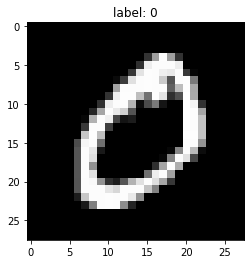

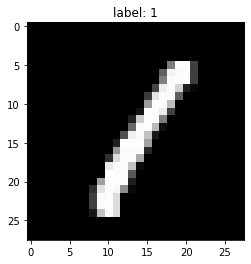

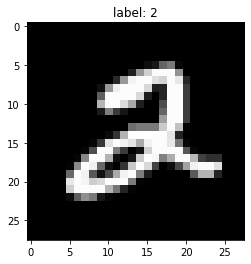

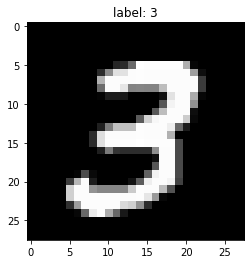

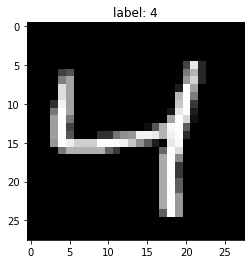

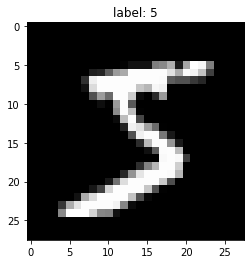

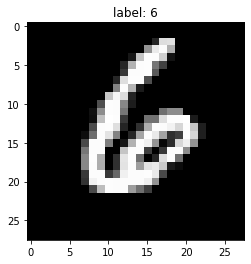

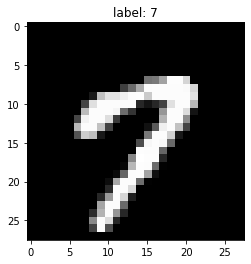

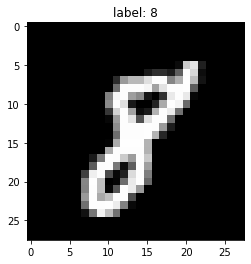

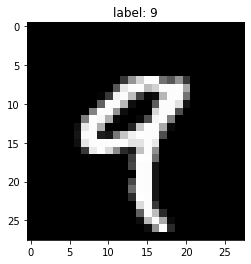

In [ ]:
for idx in indexs:
    img, label = preview_train[idx]
    plt.title(f'label: {label}')
    plt.imshow(img, cmap='gray')
    plt.show()

## 宣告損失函數&優化器

In [ ]:
# 計算輸出的損失函數(Loss function)
loss_func = CrossEntropyLoss() # 計算機率的Loss我們會用交叉熵(CrossEntropy)
# 這是優化器(Optimizer), 使得模型能更好的學習, 可以想成是學習的策略
optimizer = Adadelta(model.parameters(), lr=LR)

## 訓練

In [ ]:
# 把每個EPOCH的Loss記錄下來
losses_log = []
# 開始訓練
for epoch in trange(1, EPOCHS+1, desc='Epoch', unit='次'):
    # 忘記剛才學習的方向
    losses = 0
    optimizer.zero_grad()
    # 給模型看很多的圖
    for batch_x, batch_y in tqdm(mnist_train, desc='訓練進度', unit='batch'):
        # 把圖跟答案放到GPU
        x = batch_x.cuda()
        y = batch_y.cuda()
        # 問模型這是什麼
        predict = model(x)
        # 根據模型的回答評分
        loss = loss_func(predict, y)
        # 告訴模型哪裡錯了
        loss.backward()
        # 把所有錯的地方跟程度加起來
        losses += loss.item()
        # 模型根據上面給的方向學習
        optimizer.step()
    

    # 測試, 給模型看從沒看過的圖, 看他是真懂還是假懂
    test_losses = 0
    trues = []
    predicts = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm(mnist_test, desc='測試進度', unit='張'):
            x = batch_x.cuda()
            y = batch_y.cuda()

            predict = model(x)
            test_losses += loss_func(predict, y).item()
            # 選模型認為最有可能的數字
            predict = torch.argmax(predict, dim=1, keepdim=True)
            trues += y.tolist()
            predicts += predict.tolist()
        # 記錄Loss
        losses_log.append(test_losses)
        # 印出這次Epoch的總結與統計
        print(f'EPOCH {epoch} | 訓練資料的Loss: {losses/len(mnist_train.dataset)} | 測試資料的Loss: {test_losses/len(mnist_test.dataset)}\n{classification_report(trues, predicts, labels=[l for l in range(0, 10)], digits=4)}')




EPOCH 1 | 訓練資料的Loss: 0.0026029145861665407 | 測試資料的Loss: 0.763801213922859
              precision    recall  f1-score   support

           0     0.9506    0.8837    0.9159       980
           1     0.9438    0.9172    0.9303      1135
           2     0.8696    0.8333    0.8511      1032
           3     0.6787    0.8535    0.7561      1010
           4     0.7773    0.8350    0.8051       982
           5     0.6480    0.8150    0.7219       892
           6     0.8865    0.9290    0.9072       958
           7     0.8355    0.8599    0.8476      1028
           8     0.8340    0.6345    0.7207       974
           9     0.8353    0.6184    0.7107      1009

    accuracy                         0.8192     10000
   macro avg     0.8259    0.8180    0.8167     10000
weighted avg     0.8290    0.8192    0.8190     10000




EPOCH 2 | 訓練資料的Loss: 0.0022238814344008764 | 測試資料的Loss: 0.6046949765255494
              precision    recall  f1-score   support

           0     0.9509    0.8898    0.9193       980
           1     0.8979    0.9612    0.9285      1135
           2     0.8036    0.8721    0.8364      1032
           3     0.7423    0.8554    0.7948      1010
           4     0.9175    0.7363    0.8169       982
           5     0.8290    0.7119    0.7660       892
           6     0.8643    0.9238    0.8930       958
           7     0.8864    0.7665    0.8221      1028
           8     0.7327    0.8049    0.7671       974
           9     0.7650    0.7939    0.7792      1009

    accuracy                         0.8343     10000
   macro avg     0.8390    0.8316    0.8324     10000
weighted avg     0.8395    0.8343    0.8340     10000




EPOCH 3 | 訓練資料的Loss: 0.0019322131261229516 | 測試資料的Loss: 0.4460741062364819
              precision    recall  f1-score   support

           0     0.9420    0.9449    0.9435       980
           1     0.9269    0.9604    0.9433      1135
           2     0.8520    0.8983    0.8745      1032
           3     0.9151    0.8000    0.8537      1010
           4     0.8859    0.7749    0.8267       982
           5     0.8755    0.8038    0.8381       892
           6     0.8887    0.9248    0.9064       958
           7     0.9072    0.8658    0.8860      1028
           8     0.7717    0.8398    0.8043       974
           9     0.7565    0.8652    0.8072      1009

    accuracy                         0.8696     10000
   macro avg     0.8721    0.8678    0.8684     10000
weighted avg     0.8728    0.8696    0.8696     10000




EPOCH 4 | 訓練資料的Loss: 0.0018979273460805416 | 測試資料的Loss: 0.6904401013657967
              precision    recall  f1-score   support

           0     0.5640    0.9622    0.7112       980
           1     0.9084    0.9612    0.9341      1135
           2     0.8794    0.7771    0.8251      1032
           3     0.9183    0.6010    0.7265      1010
           4     0.6221    0.8381    0.7141       982
           5     0.8732    0.6794    0.7642       892
           6     0.7900    0.9384    0.8578       958
           7     0.9374    0.7578    0.8381      1028
           8     0.8121    0.4261    0.5589       974
           9     0.6783    0.7106    0.6941      1009

    accuracy                         0.7682     10000
   macro avg     0.7983    0.7652    0.7624     10000
weighted avg     0.8004    0.7682    0.7653     10000




EPOCH 5 | 訓練資料的Loss: 0.002062793404360612 | 測試資料的Loss: 0.49019618371200613
              precision    recall  f1-score   support

           0     0.9698    0.8510    0.9065       980
           1     0.8705    0.9771    0.9207      1135
           2     0.8818    0.8382    0.8594      1032
           3     0.7970    0.8317    0.8140      1010
           4     0.8051    0.8411    0.8227       982
           5     0.7515    0.8240    0.7861       892
           6     0.9515    0.8601    0.9035       958
           7     0.8941    0.8706    0.8822      1028
           8     0.7481    0.8018    0.7740       974
           9     0.8177    0.7423    0.7782      1009

    accuracy                         0.8458     10000
   macro avg     0.8487    0.8438    0.8447     10000
weighted avg     0.8499    0.8458    0.8463     10000




EPOCH 6 | 訓練資料的Loss: 0.0018609599083662034 | 測試資料的Loss: 0.5969324443360008
              precision    recall  f1-score   support

           0     0.9212    0.9306    0.9259       980
           1     0.9567    0.9533    0.9550      1135
           2     0.8244    0.9234    0.8711      1032
           3     0.8599    0.6683    0.7521      1010
           4     0.7475    0.8259    0.7847       982
           5     0.7483    0.8632    0.8017       892
           6     0.8932    0.9426    0.9172       958
           7     0.9052    0.8638    0.8840      1028
           8     0.8833    0.6992    0.7805       974
           9     0.7842    0.8246    0.8039      1009

    accuracy                         0.8507     10000
   macro avg     0.8524    0.8495    0.8476     10000
weighted avg     0.8547    0.8507    0.8494     10000




EPOCH 7 | 訓練資料的Loss: 0.0018514905648926894 | 測試資料的Loss: 0.5085339403203665
              precision    recall  f1-score   support

           0     0.9175    0.9082    0.9128       980
           1     0.9327    0.9648    0.9485      1135
           2     0.8567    0.8808    0.8686      1032
           3     0.8844    0.8713    0.8778      1010
           4     0.8216    0.8350    0.8283       982
           5     0.8672    0.8274    0.8468       892
           6     0.8473    0.9154    0.8801       958
           7     0.9083    0.8093    0.8560      1028
           8     0.8052    0.7977    0.8014       974
           9     0.7981    0.8186    0.8082      1009

    accuracy                         0.8644     10000
   macro avg     0.8639    0.8629    0.8629     10000
weighted avg     0.8651    0.8644    0.8642     10000




EPOCH 8 | 訓練資料的Loss: 0.0015688154188295206 | 測試資料的Loss: 0.6465173139754121
              precision    recall  f1-score   support

           0     0.9621    0.9327    0.9472       980
           1     0.9447    0.9630    0.9538      1135
           2     0.8676    0.8828    0.8751      1032
           3     0.8747    0.8228    0.8480      1010
           4     0.8389    0.8747    0.8564       982
           5     0.8522    0.8599    0.8560       892
           6     0.9007    0.9468    0.9232       958
           7     0.8976    0.8696    0.8834      1028
           8     0.8081    0.8563    0.8315       974
           9     0.8512    0.7879    0.8183      1009

    accuracy                         0.8805     10000
   macro avg     0.8798    0.8796    0.8793     10000
weighted avg     0.8809    0.8805    0.8803     10000




EPOCH 9 | 訓練資料的Loss: 0.0017169001698493958 | 測試資料的Loss: 0.5169614301483727
              precision    recall  f1-score   support

           0     0.8751    0.9582    0.9148       980
           1     0.9254    0.9401    0.9327      1135
           2     0.8628    0.8895    0.8760      1032
           3     0.8684    0.8752    0.8718      1010
           4     0.7137    0.8859    0.7905       982
           5     0.8832    0.8139    0.8471       892
           6     0.9376    0.8946    0.9156       958
           7     0.8861    0.8327    0.8586      1028
           8     0.8131    0.8172    0.8152       974
           9     0.8434    0.6620    0.7418      1009

    accuracy                         0.8581     10000
   macro avg     0.8609    0.8569    0.8564     10000
weighted avg     0.8616    0.8581    0.8574     10000




EPOCH 10 | 訓練資料的Loss: 0.0024463119986156624 | 測試資料的Loss: 4.77024366325438
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.1135    1.0000    0.2039      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1135     10000
   macro avg     0.0114    0.1000    0.0204     10000
weighted avg     0.0129    0.1135    0.0231     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



EPOCH 11 | 訓練資料的Loss: 0.010054443192481995 | 測試資料的Loss: 2.329950681614876
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.1135    1.0000    0.2039      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1135     10000
   macro avg     0.0114    0.1000    0.0204     10000
weighted avg     0.0129    0.1135    0.0231     10000




EPOCH 12 | 訓練資料的Loss: 0.0090793163895607 | 測試資料的Loss: 2.305833491563797
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.1032    1.0000    0.1871      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1032     10000
   macro avg     0.0103    0.1000    0.0187     10000
weighted avg     0.0107    0.1032    0.0193     10000




EPOCH 13 | 訓練資料的Loss: 0.00903266543149948 | 測試資料的Loss: 2.3063678505420686
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0982    1.0000    0.1788       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.0982     10000
   macro avg     0.0098    0.1000    0.0179     10000
weighted avg     0.0096    0.0982    0.0176     10000




EPOCH 14 | 訓練資料的Loss: 0.009029936325550079 | 測試資料的Loss: 2.304330808520317
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.1028    1.0000    0.1864      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1028     10000
   macro avg     0.0103    0.1000    0.0186     10000
weighted avg     0.0106    0.1028    0.0192     10000




EPOCH 15 | 訓練資料的Loss: 0.009029593686262766 | 測試資料的Loss: 2.3054124530792235
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.1009    1.0000    0.1833      1009

    accuracy                         0.1009     10000
   macro avg     0.0101    0.1000    0.0183     10000
weighted avg     0.0102    0.1009    0.0185     10000




EPOCH 16 | 訓練資料的Loss: 0.009043575123945873 | 測試資料的Loss: 2.3134320292711257
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.1032    1.0000    0.1871      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1032     10000
   macro avg     0.0103    0.1000    0.0187     10000
weighted avg     0.0107    0.1032    0.0193     10000




EPOCH 17 | 訓練資料的Loss: 0.009048356922467549 | 測試資料的Loss: 2.310068730688095
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.1028    1.0000    0.1864      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1028     10000
   macro avg     0.0103    0.1000    0.0186     10000
weighted avg     0.0106    0.1028    0.0192     10000




EPOCH 18 | 訓練資料的Loss: 0.009036809774239858 | 測試資料的Loss: 2.3087795605659487
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.0000    0.0000    0.0000      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.1010    1.0000    0.1835      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1010     10000
   macro avg     0.0101    0.1000    0.0183     10000
weighted avg     0.0102    0.1010    0.0185     10000




EPOCH 19 | 訓練資料的Loss: 0.009032167108853658 | 測試資料的Loss: 2.3058026797533033
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       980
           1     0.1135    1.0000    0.2039      1135
           2     0.0000    0.0000    0.0000      1032
           3     0.0000    0.0000    0.0000      1010
           4     0.0000    0.0000    0.0000       982
           5     0.0000    0.0000    0.0000       892
           6     0.0000    0.0000    0.0000       958
           7     0.0000    0.0000    0.0000      1028
           8     0.0000    0.0000    0.0000       974
           9     0.0000    0.0000    0.0000      1009

    accuracy                         0.1135     10000
   macro avg     0.0114    0.1000    0.0204     10000
weighted avg     0.0129    0.1135    0.0231     10000



## 把訓練過程的Loss 畫出來

In [ ]:
# X 軸是Epoch, Y 是對應Epoch 的Loss
plt.plot(list(range(1, EPOCHS+1)), losses_log)
plt.xticks(list(range(1, EPOCHS+1)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, EPOCHS)